<h2><center> EEG - N. 9 </center></h2>

<h3><center> MANU 465 101 </center></h3>

[Set phase](#Set-phase)

 - [Import libraries](#Import-libraries)
 - [Setting path](#Setting-path)

[Features generation](#Features-generation)


[Import procedure](#Import-procedure)
  - [Lists initialization](#Lists-initialization)
  - [Final dataset creation](#Final-dataset-creation)
       
[Conclusions](#Conclusions)
       

# Introduction
The following is the code for MANU 465 EEG Group #9 Capstone Project. The code is written in Python and uses the following libraries:

-   Pandas
-   Numpy
-   Matplotlib
-   Seaborn
-   Scikit-learn

## Objective 
Our objective is to use machine learning to determine if a person is left or right handed based on brainwave data using brainwave data collected by the MUSE 2. Muse 2 is a multi-sensor electroencephalograph (EEG) device that provides real-time biofeedback on brain activity, heartbeat, breathing, and movement by attaching a set of electrodes to the scalp to measure the electrical activity of the brain.

## Dataset
The dataset was constructed from approximately 90 test subjects. Each subject was asked to perform 4 tasks:
- 1) drawing in a circle with left hand
- 2) drawing in a circle with right hand
- 3) writing a sentence with left hand
- 4) writing a sentence with right hand

The data from each of these tasks were saved in a csv file and classified as either left hand or right hand dominant based on the test subject. Four additional features were also added for our analysis:
- 1) Participant ID
- 2) Gender
- 3) English Native speaker
- 4) left or right handed

# Set phase

### Import libraries

In [281]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

### Setting path

In [282]:
#delimiter = "\\" # for windows
delimiter = "//"  # for os system

# add your own path:

#path = r"C:/Users/chies/OneDrive/Desktop/CLEANED DATASET- code is working/Data Collection/Unprocessed Dataset"
#path = r"/Users/sofiacaltabiano/Desktop/CLEANED DATASET- code is working/Data Collection/Unprocessed Dataset"
#path = r"C:\Users\M0NYP\Desktop\Data"
path=r"/Users/sofiacaltabiano/Desktop/MANU-465-EEG4-main-2/Unprocessed Data"

In [283]:
os.chdir(path)

Get all the filenames in the folder indicated by the previous path

In [284]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [285]:
len(all_filenames)

365

# Features generation

In order to condensate each csv file in only one row, we need to use summary metrics. 

For each wave, which corresponds to 4 columns in each file, we want one value of mean, one value of std, and so on. Then all these values will be stored in a final dataset in a unique row that represents one csv file.

In [286]:
from scipy import stats 
def mean(x):
    return np.mean(x, axis=0)
def std(x):
    return np.std(x, axis=0)
def ptp(x):
    return np.ptp(x, axis=0)
def var(x):
    return np.var(x, axis=0)
def minim(x):
    return np.min(x, axis=0)
def maxim(x):
    return np.max(x, axis=0)
def argminim(x):
    return np.argmin(x, axis=0)
def argmaxim(x):
    return np.argmax(x, axis=0)
def rms(x):
    return np.sqrt(np.mean(x**2, axis=0))
def skewness(x):
    return stats.skew(x,axis=0)
def kurtosis(x):
    return stats.kurtosis(x,axis=0)

def concatenate_features(x):
    '''''''''
    this function apply several functions defined above.
    It takes as input a numpy array.
    It outputs a vector with the value of each function: mean, std, ...
    '''''''''
    return mean(x),std(x),ptp(x),var(x),minim(x),maxim(x),argminim(x),argmaxim(x),rms(x),skewness(x),kurtosis(x)

# Import procedure

## Lists initialization

Creation of useful lists and the final dataset initialization.

The final dataset should has some columns related to information about the patient (Gender, Dominance hand, ID Number, Test, ...), 12 columns for each wave (for each wave we have mean, std, ... (in total 12 new features)). 

Since we tested each patient 4 times, the dimension of the final dataset will be:
- number rows = 4 * number of patients = number of csv files
- number columns = 12 * 5 (features * waves numbers) + fixed qualities (persona data)

In [287]:
waves = ["Delta", "Theta", "Alpha", "Beta", "Gamma"] # names of waves we are interested in

In [288]:
test_list = []
dominance_list = []
english_list = []
gender_list = []
participant_list = []

# dictionary to store all the values for one dataframe
final_dic = {}

## Final dataset creation

In [289]:
for name in all_filenames: # file 6 contains string number
    
    df = pd.read_csv(path + delimiter + name)

    df = df.drop(["Elements"], axis=1)
    df = df.dropna() # drop Nan values
    df = df.reset_index(drop=True) # restart index
    
    # Add to lists the values related to patient profile
    test_list.append(df["Test"][0])
    dominance_list.append(df["Dominance"][0])
    english_list.append(df["English"][0])
    gender_list.append(df["Gender"][0])
    participant_list.append(df["Participant"][0])

    # create empty list to collect mean, std, var, ... for a fixed wave
    gen_features = {}
    
    #print(name)
    
    for wave in waves: # for each waves (ALpha, Beta, Gamma, Delta, Theta)
        
        # create empty list to collect all the data in the four columns for a fixed wave
        all_values = []
        
        for col in df.columns: # for each column
            if col.split("_")[0] == wave: # if the wave is in the column name, then:
                
                # Marti code
                # to clean data, we delete columns in which the values is equal to the one 4 time points before
                for i in range(4,len(df[col])):
                    if not df[col][i] == df[col][i-4]:
                        all_values.append(df[col][i])
                #if len(all_values)!=0: # if the values are not constant, we want to add also the first 4 values
                #    for i in range(4):
                #        all_values.append(df[col][i])
                for i in range(4):
                    all_values.append(df[col][i])  
                    
        # add a list with the new features associated to the name of the wave in a dictionary
        gen_features[wave] = list( concatenate_features(np.array(all_values)) )
    
    final_dic[name] = gen_features
         
#print()

In [290]:
# create an empty dataframe
final_df = pd.DataFrame()

# assign to the column 'Test' of the final df all the values which are in the test_list
final_df["Test"] = test_list
final_df["English"] = english_list
final_df["Gender"] = gender_list
final_df["Participant"] = participant_list
final_df["Dominance"] = dominance_list


functions = ["mean", "std", "ptp","var","minim","maxim","argminim","argmaxim","rms","skewness","kurtosis"] 

for i in range(len(all_filenames)): # i indicates the row (index for each file)
    # Change the class from Left to Dominant or NonDominant
    if final_df.at[i, "Dominance"] == 'Left':
        if final_df.at[i, "Test"] =='LHC' or final_df.at[i, "Test"] =='LHS':
            final_df.at[i, "Dominance"] = 'Dominant'
        else:
            final_df.at[i, "Dominance"] = 'NonDominant'
    else: # change the class from Right to Dominant or NonDominant
        if final_df.at[i, "Test"] =='RHC' or final_df.at[i, "Test"] =='RHS':
            final_df.at[i, "Dominance"] = 'Dominant'
        else:
            final_df.at[i, "Dominance"] = 'NonDominant'
    name = all_filenames[i]
    
    for wave in waves: # for each wave
        for j in range(11): 
            # at row i, and column specified by the name of the wave and features
            final_df.at[i, wave + "_" + functions[j]] = final_dic[name][wave][j]       
            
final_df

,Test,English,Gender,Participant,Dominance,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,RHC,Yes,Female,207.0,Dominant,0.899940,0.665747,2.077104,0.443219,0.000000,...,0.541886,1.429479,0.293641,0.000000,1.429479,11.0,10.0,0.987636,-0.772636,-1.218459
1,RHC,Yes,Male,213.0,Dominant,0.608694,0.423892,1.445081,0.179685,0.000000,...,0.205054,0.649602,0.042047,-0.649602,0.000000,6.0,0.0,0.429516,0.902453,-0.492030
2,LHC,Yes,Male,216.0,NonDominant,0.875494,0.362626,1.763397,0.131497,0.108352,...,0.390930,1.608234,0.152826,-0.801319,0.806915,51.0,105.0,0.390980,0.118138,-1.113946
3,LHS,No,Female,233.0,NonDominant,0.446411,0.441269,1.590974,0.194719,-0.461474,...,0.443401,1.318344,0.196604,-0.464123,0.854221,21.0,11.0,0.521502,-0.224684,-1.448040
4,LHS,No,Male,227.0,NonDominant,1.064080,0.258707,1.281913,0.066929,0.284205,...,0.431995,1.356294,0.186619,-0.469696,0.886598,4.0,41.0,0.435640,0.584809,-1.101482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,RHS,Yes,Male,213.0,Dominant,0.843567,0.238096,0.808748,0.056690,0.427179,...,0.458538,1.329694,0.210257,-0.636977,0.692717,10.0,30.0,0.491578,1.094181,-0.549828
361,LHS,Yes,Male,216.0,NonDominant,0.597821,0.418759,1.742914,0.175359,-0.320660,...,0.359446,1.320366,0.129201,-0.732417,0.587949,45.0,12.0,0.410245,0.451790,-0.986368
362,LHC,No,Female,233.0,NonDominant,0.394034,0.396536,1.787634,0.157241,-0.342963,...,0.454963,1.754041,0.206992,-0.562493,1.191549,67.0,4.0,0.559556,-0.512365,-1.023119
363,LHC,No,Male,227.0,NonDominant,0.876730,0.337587,1.399109,0.113965,0.213437,...,0.356405,1.112231,0.127024,-0.162991,0.949240,7.0,45.0,0.468518,0.599151,-1.214869


# Exploratory Data Analysis

## Reviewing the data for some general information

Check all features

In [291]:
final_df.head()

,Test,English,Gender,Participant,Dominance,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,RHC,Yes,Female,207.0,Dominant,0.899940,0.665747,2.077104,0.443219,0.000000,...,0.541886,1.429479,0.293641,0.000000,1.429479,11.0,10.0,0.987636,-0.772636,-1.218459
1,RHC,Yes,Male,213.0,Dominant,0.608694,0.423892,1.445081,0.179685,0.000000,...,0.205054,0.649602,0.042047,-0.649602,0.000000,6.0,0.0,0.429516,0.902453,-0.492030
2,LHC,Yes,Male,216.0,NonDominant,0.875494,0.362626,1.763397,0.131497,0.108352,...,0.390930,1.608234,0.152826,-0.801319,0.806915,51.0,105.0,0.390980,0.118138,-1.113946
3,LHS,No,Female,233.0,NonDominant,0.446411,0.441269,1.590974,0.194719,-0.461474,...,0.443401,1.318344,0.196604,-0.464123,0.854221,21.0,11.0,0.521502,-0.224684,-1.448040
4,LHS,No,Male,227.0,NonDominant,1.064080,0.258707,1.281913,0.066929,0.284205,...,0.431995,1.356294,0.186619,-0.469696,0.886598,4.0,41.0,0.435640,0.584809,-1.101482


Check the shape of the dataset

In [292]:
final_df.shape

(365, 60)

Check the general info of the dataset

In [293]:
final_df.info

<bound method DataFrame.info of     Test English  Gender  Participant    Dominance  Delta_mean  Delta_std  \
0    RHC     Yes  Female        207.0     Dominant    0.899940   0.665747   
1    RHC     Yes    Male        213.0     Dominant    0.608694   0.423892   
2    LHC     Yes    Male        216.0  NonDominant    0.875494   0.362626   
3    LHS      No  Female        233.0  NonDominant    0.446411   0.441269   
4    LHS      No    Male        227.0  NonDominant    1.064080   0.258707   
..   ...     ...     ...          ...          ...         ...        ...   
360  RHS     Yes    Male        213.0     Dominant    0.843567   0.238096   
361  LHS     Yes    Male        216.0  NonDominant    0.597821   0.418759   
362  LHC      No  Female        233.0  NonDominant    0.394034   0.396536   
363  LHC      No    Male        227.0  NonDominant    0.876730   0.337587   
364  RHC      No    Male        222.0     Dominant    0.795861   0.332625   

     Delta_ptp  Delta_var  Delta_minim  ...

Check the number of duplication of the dataset

In [294]:
final_df.duplicated().sum()

1

Reviewing Data for General Information.

In [295]:
# check if there are missing values
final_df.isnull().sum()

Test              0
English           0
Gender            0
Participant       0
Dominance         0
Delta_mean        0
Delta_std         0
Delta_ptp         0
Delta_var         0
Delta_minim       0
Delta_maxim       0
Delta_argminim    0
Delta_argmaxim    0
Delta_rms         0
Delta_skewness    0
Delta_kurtosis    0
Theta_mean        0
Theta_std         0
Theta_ptp         0
Theta_var         0
Theta_minim       0
Theta_maxim       0
Theta_argminim    0
Theta_argmaxim    0
Theta_rms         0
Theta_skewness    0
Theta_kurtosis    0
Alpha_mean        0
Alpha_std         0
Alpha_ptp         0
Alpha_var         0
Alpha_minim       0
Alpha_maxim       0
Alpha_argminim    0
Alpha_argmaxim    0
Alpha_rms         0
Alpha_skewness    0
Alpha_kurtosis    0
Beta_mean         0
Beta_std          0
Beta_ptp          0
Beta_var          0
Beta_minim        0
Beta_maxim        0
Beta_argminim     0
Beta_argmaxim     0
Beta_rms          0
Beta_skewness     0
Beta_kurtosis     0
Gamma_mean        0


There are no missing values in the dataset.

## Reviewing overall statistical information

Review the mean, std, min/max, quartiles of the dataset.

In [296]:
final_df.describe()

,Participant,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,Delta_maxim,Delta_argminim,Delta_argmaxim,Delta_rms,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,206.309589,0.608656,0.452761,1.696139,0.282395,-0.291525,1.404614,26.876712,32.723288,0.808289,...,0.378927,1.323996,0.199628,-0.450529,0.873467,28.054795,33.983562,0.536349,-0.105902,-0.333478
std,80.532568,0.294932,0.278595,0.945195,0.534275,0.889820,0.379694,28.699535,36.236519,0.294125,...,0.237059,0.811416,0.338042,0.776182,0.373508,27.574619,34.638712,0.275273,0.848811,1.975837
min,101.000000,-0.870208,0.000000,0.000000,0.000000,-4.902787,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-3.782331,0.000000,0.000000,0.000000,0.000000,-3.636304,-3.000000
25%,124.000000,0.462445,0.335858,1.303066,0.112801,-0.277085,1.243993,8.000000,9.000000,0.643730,...,0.247005,0.911217,0.061012,-0.540156,0.648738,11.000000,9.000000,0.374519,-0.527832,-1.284745
50%,216.000000,0.633329,0.392601,1.513336,0.154135,0.000000,1.430363,19.000000,24.000000,0.790891,...,0.341978,1.198437,0.116949,-0.302985,0.909167,20.000000,25.000000,0.496325,0.000000,-0.880861
75%,304.000000,0.800913,0.470791,1.824453,0.221644,0.000000,1.631372,36.000000,43.000000,0.939478,...,0.441850,1.498746,0.195231,0.000000,1.144837,36.000000,45.000000,0.649068,0.378946,-0.115841
max,326.000000,1.248197,2.034025,6.260528,4.137260,0.769124,2.290788,185.000000,271.000000,2.065605,...,1.525133,5.008102,2.326031,0.702778,1.850231,188.000000,247.000000,1.761072,2.369014,13.832200


## Getting some insights by plotting differnet variables

Plot the histograms to view the general distributional characteristics of dataset variables.

array([[<AxesSubplot:title={'center':'Participant'}>,
        <AxesSubplot:title={'center':'Delta_mean'}>,
        <AxesSubplot:title={'center':'Delta_std'}>,
        <AxesSubplot:title={'center':'Delta_ptp'}>,
        <AxesSubplot:title={'center':'Delta_var'}>,
        <AxesSubplot:title={'center':'Delta_minim'}>,
        <AxesSubplot:title={'center':'Delta_maxim'}>],
       [<AxesSubplot:title={'center':'Delta_argminim'}>,
        <AxesSubplot:title={'center':'Delta_argmaxim'}>,
        <AxesSubplot:title={'center':'Delta_rms'}>,
        <AxesSubplot:title={'center':'Delta_skewness'}>,
        <AxesSubplot:title={'center':'Delta_kurtosis'}>,
        <AxesSubplot:title={'center':'Theta_mean'}>,
        <AxesSubplot:title={'center':'Theta_std'}>],
       [<AxesSubplot:title={'center':'Theta_ptp'}>,
        <AxesSubplot:title={'center':'Theta_var'}>,
        <AxesSubplot:title={'center':'Theta_minim'}>,
        <AxesSubplot:title={'center':'Theta_maxim'}>,
        <AxesSubplot:title={'c

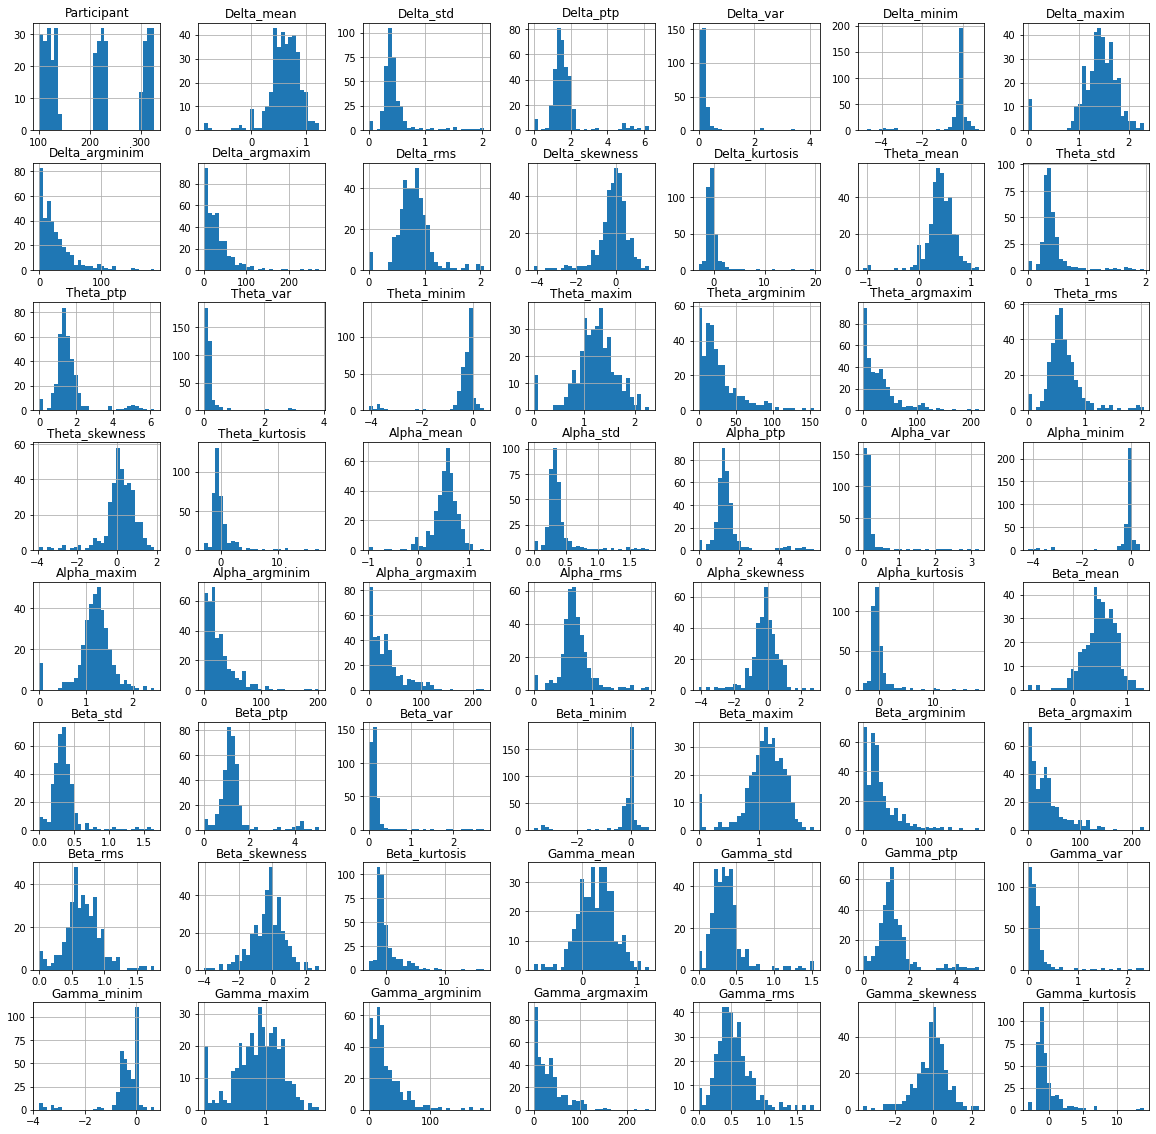

In [74]:
final_df.hist(bins = 30, figsize = (20,20))

KeyboardInterrupt: 

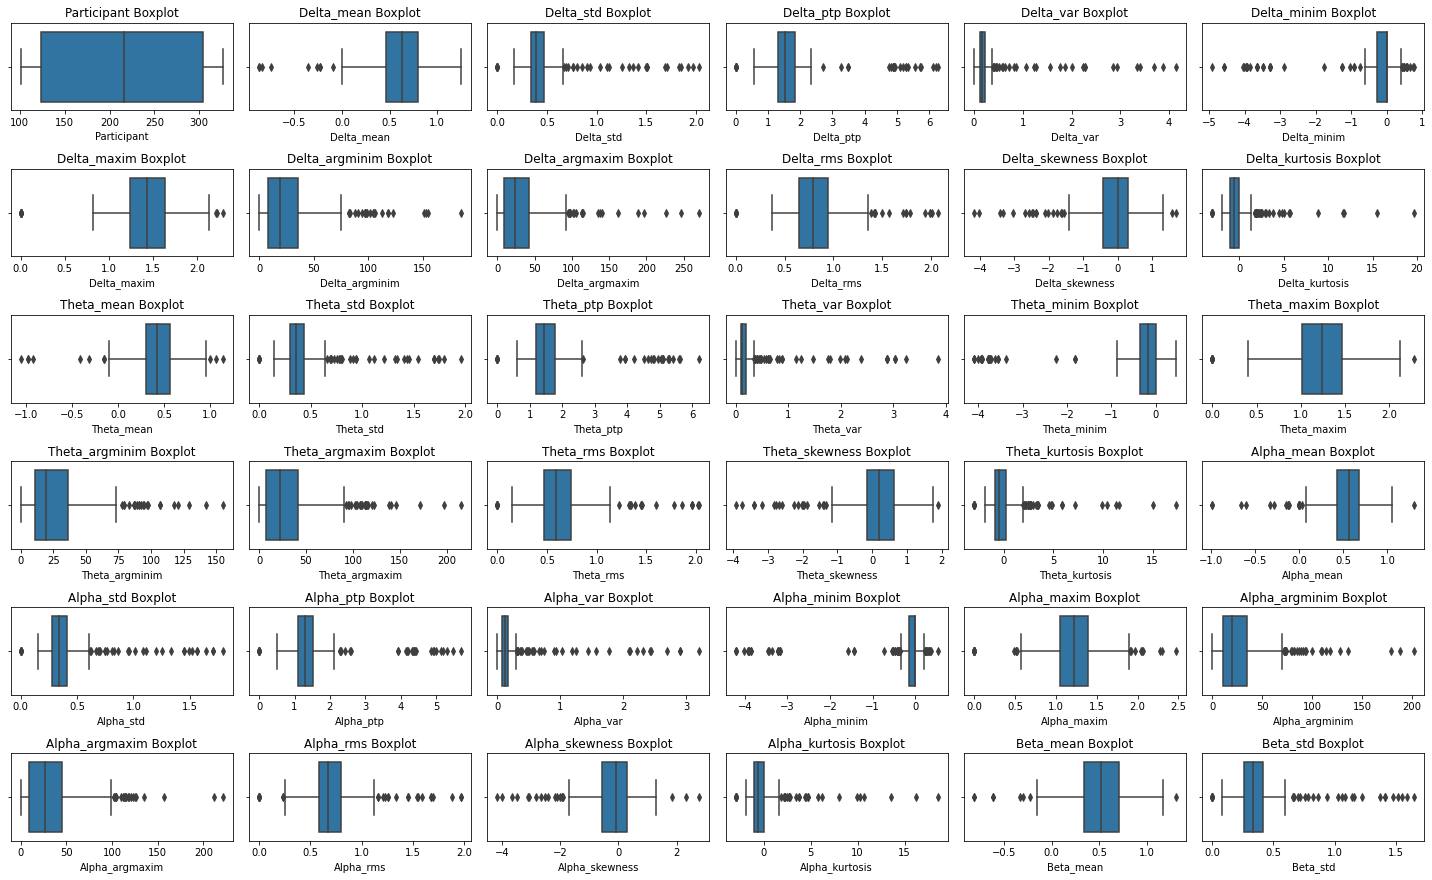

In [75]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(20,20))
for i, j in enumerate(final_df.describe().columns):
    plt.subplot(10,6, i+1)
    sns.boxplot(x=final_df[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()
    
plt.show()

## Visualizing the data relationship

To identify Pair the best set of features to explain a relationship between two variables, pairplot is used.

In [21]:
# This line will take a long processing time
# pairplot = sns.pairplot(final_df, corner=True,height=3)
# plt.show(pairplot)

Distribution of the features.

C:\Users\muyan\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


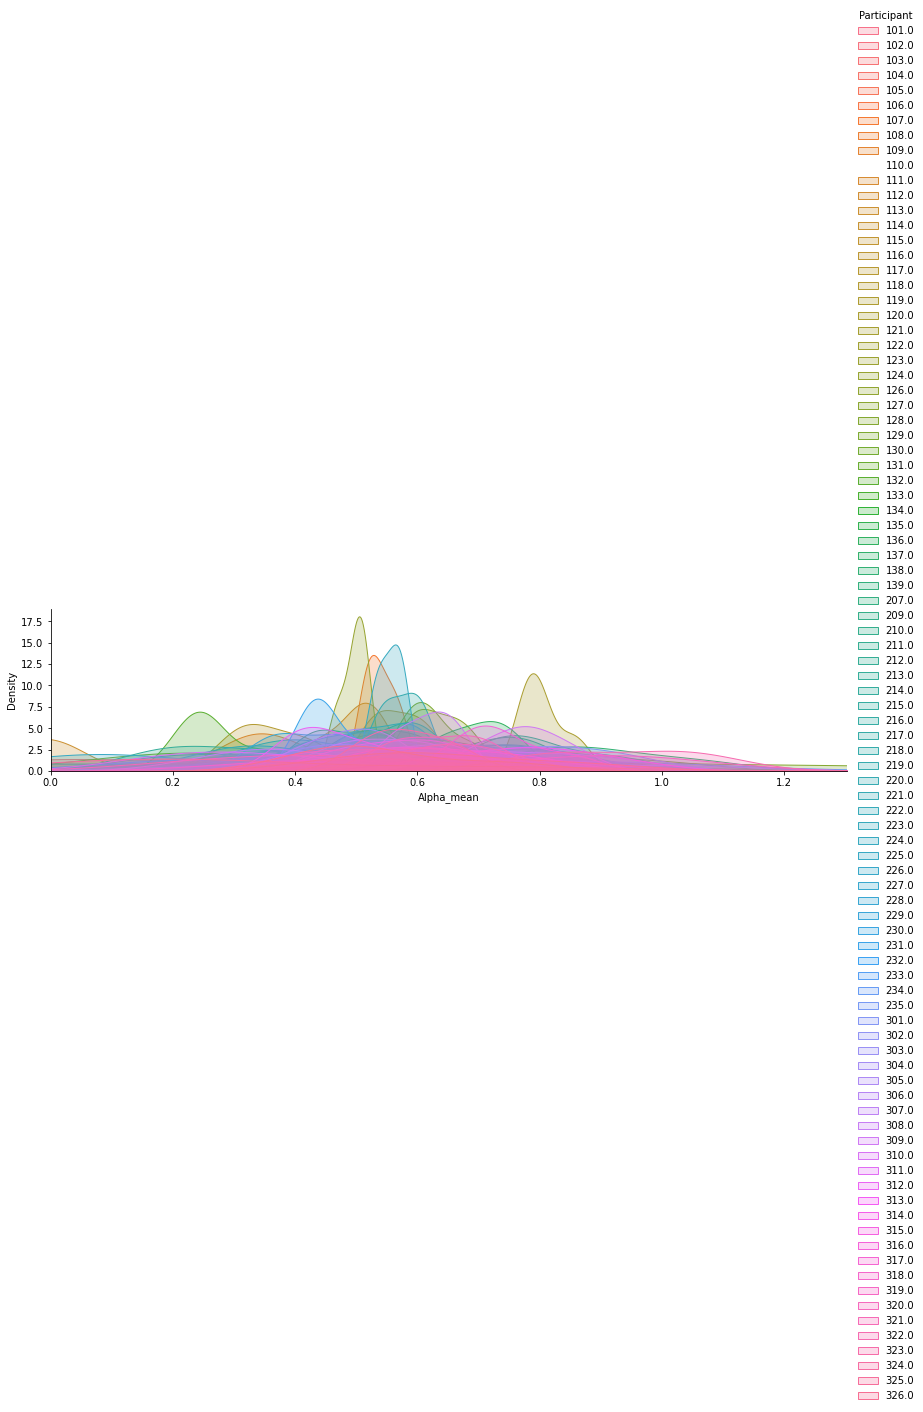

In [18]:
# make a function to plot the distribution of the features
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()))
    facet.add_legend()
    plt.show()

# plot the distribution of the features
plot_distribution(final_df, var='Alpha_mean', target='Participant')

As we can see, the distribution of the features is not normal. We will need to normalize the data before applying the machine learning algorithms using the StandardScaler() function (see the next section).

## Check correlation

In [21]:
r_matrix = final_df.corr()
r_matrix.head()

,Participant,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,Delta_maxim,Delta_argminim,Delta_argmaxim,Delta_rms,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
Participant,1.000000,0.238136,-0.042175,-0.023050,-0.088345,0.112129,0.205398,0.071918,-0.027475,0.071783,...,-0.121347,-0.050009,-0.133000,0.084624,0.067214,0.096530,-0.023458,-0.084817,0.099409,0.092195
Delta_mean,0.238136,1.000000,-0.346664,-0.214081,-0.448986,0.510126,0.662563,0.160222,0.138585,0.236687,...,-0.286583,-0.172857,-0.458713,0.318439,0.286224,0.121846,0.084329,-0.219823,0.185124,-0.005454
Delta_std,-0.042175,-0.346664,1.000000,0.907352,0.953763,-0.877326,0.202696,-0.176883,-0.121233,0.760843,...,0.807678,0.752489,0.868492,-0.814115,-0.057079,-0.187201,-0.066996,0.635626,-0.423012,0.359767
Delta_ptp,-0.023050,-0.214081,0.907352,1.000000,0.846294,-0.916116,0.342425,-0.011739,0.028826,0.707292,...,0.786505,0.857958,0.786970,-0.868011,0.060044,-0.024959,0.112895,0.612630,-0.501841,0.556016
Delta_var,-0.088345,-0.448986,0.953763,0.846294,1.000000,-0.882414,0.038777,-0.167481,-0.123968,0.706116,...,0.806753,0.724268,0.916295,-0.806742,-0.103064,-0.180972,-0.091170,0.635886,-0.401611,0.277837


<AxesSubplot:title={'center':'Correlatin Heatmap'}>

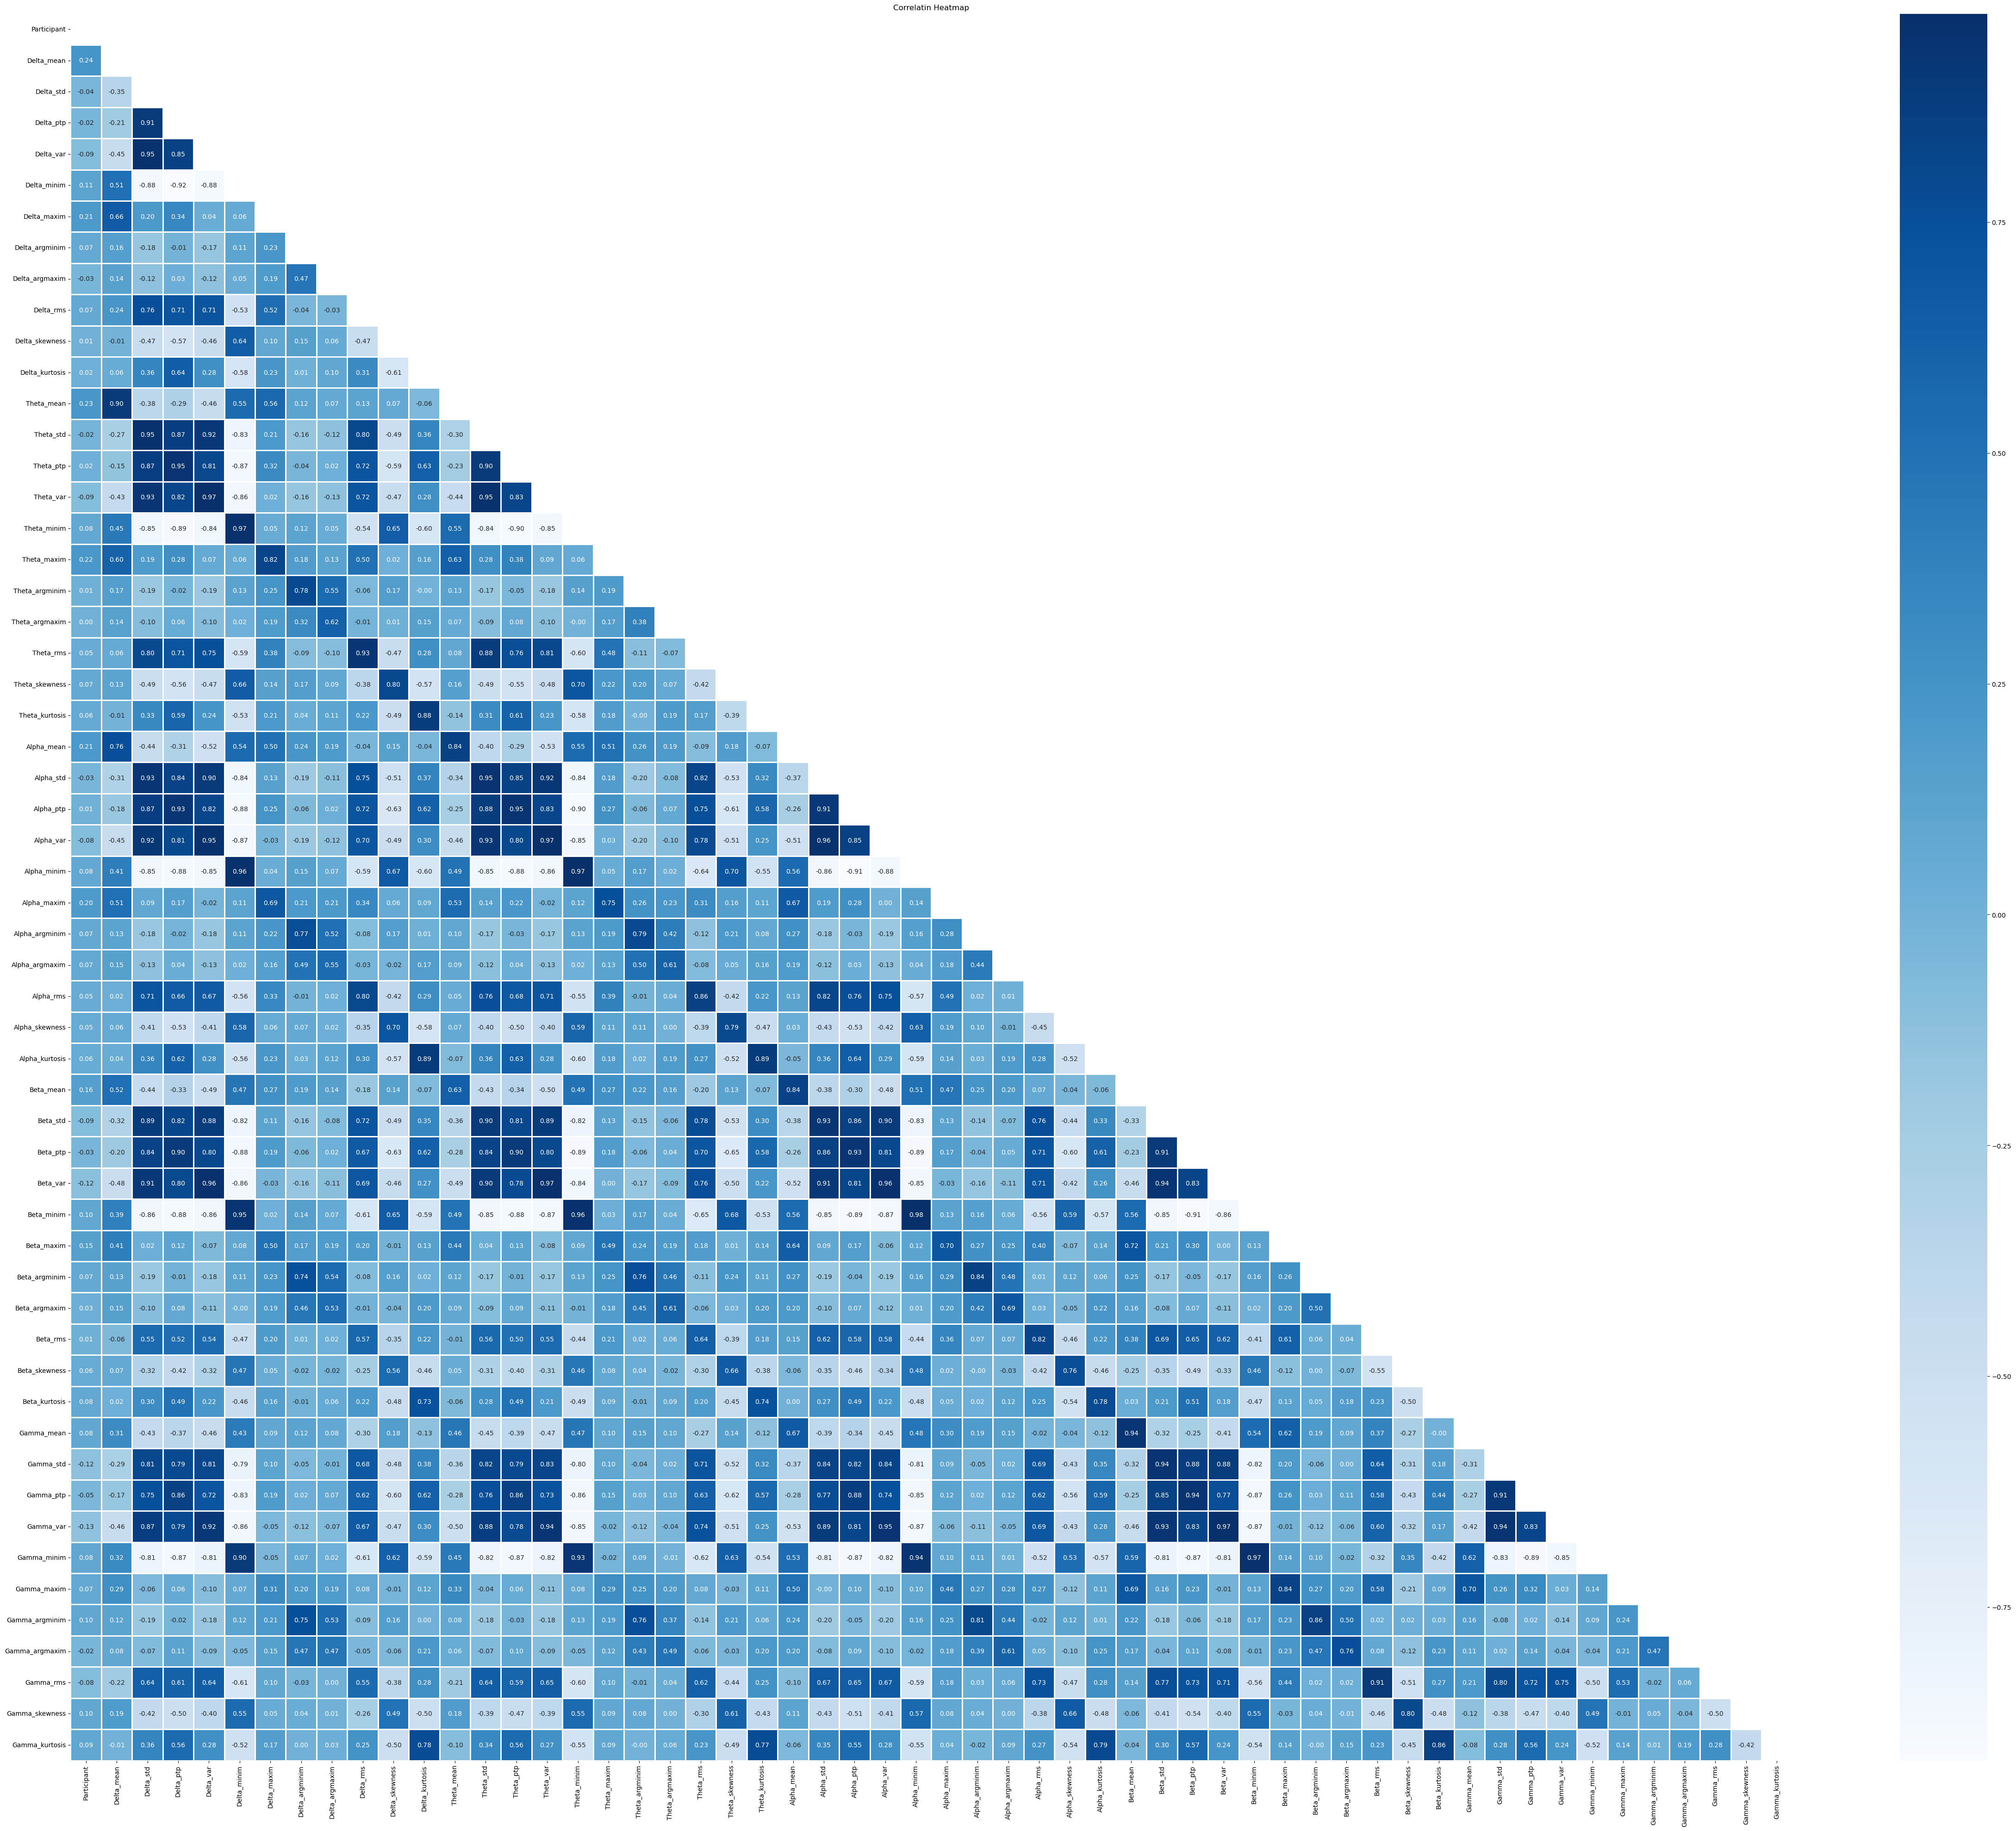

In [22]:
r_mask = np.triu(np.ones_like(r_matrix, dtype = bool))
from seaborn import heatmap
plt.figure(figsize = [60,50], dpi = 100)
plt.title('Correlatin Heatmap')
heatmap(r_matrix, mask=r_mask, annot=True, lw=1, linecolor='White', cmap='Blues', fmt = "0.2f")

Since the correlation matrix is difficult to read, the correlation higher than 0.5 is extracted and flattened.

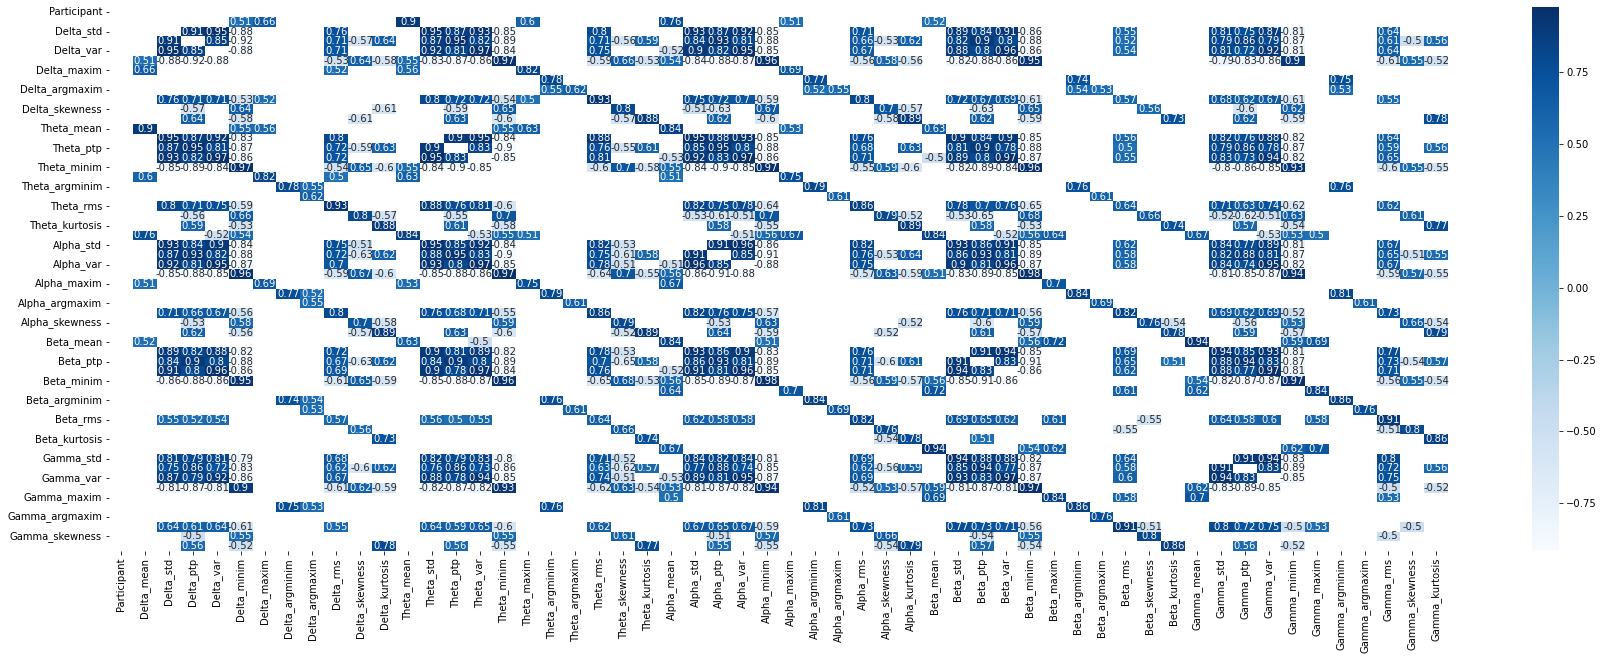

In [53]:
dfCorr = final_df.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Blues")
plt.show()

Pairs with correlation higher than 0.7 are listed.

In [61]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(final_df, .7)

Delta_minim  Delta_ptp     -0.916116
Alpha_ptp    Alpha_minim   -0.910509
Beta_ptp     Beta_minim    -0.908393
Theta_minim  Theta_ptp     -0.899708
Alpha_ptp    Theta_minim   -0.895381
                              ...   
Theta_var    Alpha_var      0.970002
Beta_var     Gamma_var      0.970819
Theta_minim  Alpha_minim    0.973443
Alpha_minim  Beta_minim     0.975683
Participant  Participant         NaN
Length: 269, dtype: float64

# Pre processing

Check the type of each variable

In [297]:
final_df.dtypes

Test               object
English            object
Gender             object
Participant       float64
Dominance          object
Delta_mean        float64
Delta_std         float64
Delta_ptp         float64
Delta_var         float64
Delta_minim       float64
Delta_maxim       float64
Delta_argminim    float64
Delta_argmaxim    float64
Delta_rms         float64
Delta_skewness    float64
Delta_kurtosis    float64
Theta_mean        float64
Theta_std         float64
Theta_ptp         float64
Theta_var         float64
Theta_minim       float64
Theta_maxim       float64
Theta_argminim    float64
Theta_argmaxim    float64
Theta_rms         float64
Theta_skewness    float64
Theta_kurtosis    float64
Alpha_mean        float64
Alpha_std         float64
Alpha_ptp         float64
Alpha_var         float64
Alpha_minim       float64
Alpha_maxim       float64
Alpha_argminim    float64
Alpha_argmaxim    float64
Alpha_rms         float64
Alpha_skewness    float64
Alpha_kurtosis    float64
Beta_mean   

We notice that are all float, exept English, Dominance, Gender and Test. Thus, to use these variables in several algorithms it is necessary to encode them as numeric.

Moreover we need to remember also that Participant is an id, and the value of this variable should not influence the result of the algorithm, so we are going to drop it.

## Split in X and y

In [298]:
y = final_df["Dominance"]
X = final_df.drop(["Dominance", "Participant"], axis=1)

## Encoding indipendent variables

In [299]:
obj_df = X.select_dtypes(include=['object']).copy()
obj_df.head()

,Test,English,Gender
0,RHC,Yes,Female
1,RHC,Yes,Male
2,LHC,Yes,Male
3,LHS,No,Female
4,LHS,No,Male


In [300]:
for col in obj_df.columns:
    X[col] = obj_df[col].astype('category').cat.codes
X.head()

,Test,English,Gender,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,Delta_maxim,Delta_argminim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,2,1,0,0.899940,0.665747,2.077104,0.443219,0.000000,2.077104,11.0,...,0.541886,1.429479,0.293641,0.000000,1.429479,11.0,10.0,0.987636,-0.772636,-1.218459
1,2,1,1,0.608694,0.423892,1.445081,0.179685,0.000000,1.445081,0.0,...,0.205054,0.649602,0.042047,-0.649602,0.000000,6.0,0.0,0.429516,0.902453,-0.492030
2,0,1,1,0.875494,0.362626,1.763397,0.131497,0.108352,1.871749,37.0,...,0.390930,1.608234,0.152826,-0.801319,0.806915,51.0,105.0,0.390980,0.118138,-1.113946
3,1,0,0,0.446411,0.441269,1.590974,0.194719,-0.461474,1.129500,20.0,...,0.443401,1.318344,0.196604,-0.464123,0.854221,21.0,11.0,0.521502,-0.224684,-1.448040
4,1,0,1,1.064080,0.258707,1.281913,0.066929,0.284205,1.566118,7.0,...,0.431995,1.356294,0.186619,-0.469696,0.886598,4.0,41.0,0.435640,0.584809,-1.101482


## Split in train and test

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

print("The shape of X_train is:", X_train.shape)
print("The shape of X_test is:", X_test.shape)
print('')
print("The shape of y_train is:", y_train.shape)
print("The shape of y_test is:", y_test.shape)

The shape of X_train is: (292, 58)
The shape of X_test is: (73, 58)

The shape of y_train is: (292,)
The shape of y_test is: (73,)


## Feature scaling

In [302]:
#For label data (y) always use LabelEncoder
LaEnc = LabelEncoder()
y_train = LaEnc.fit_transform(y_train)
y_train

y_test = LaEnc.transform(y_test)
y_test

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1])

In [303]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Classification analysis

## KNN

In [ ]:
KNNclassifier = KNeighborsClassifier(n_neighbors = 3, metric = 'euclidean', p = 2)
KNNclassifier.fit(X_train, y_train)

y_pred = KNNclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of KNN:", acc*100,'\n')

KNNacc = acc

## SVM linear

In [ ]:
SVMclassifier = SVC(kernel = 'linear', random_state = 1)
SVMclassifier.fit(X_train, y_train)

y_pred = SVMclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of SVM linear:", acc*100,'\n')

linearSVMacc = acc

## SVM non linear

In [ ]:
SVMclassifier = SVC(kernel = 'rbf', random_state = 1)
SVMclassifier.fit(X_train, y_train)

y_pred = SVMclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of SVM rbf:", acc*100,'\n')

nonlinearSVMacc = acc

## Naive Bayes Classifier

In [ ]:
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

y_pred = NBclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of Naive bayes Classifier:", acc*100,'\n')

NBacc = acc

## Random Forest

In [ ]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)
Forestclassifier.fit(X_train, y_train)

y_pred = Forestclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of random forest:", acc*100,'\n')

Forestacc = acc

## Decision Tree

In [ ]:
DecisionTreeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DecisionTreeclassifier.fit(X_train, y_train)

y_pred = DecisionTreeclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of decision tree:", acc*100,'\n')

Decisionacc = acc

## Logistic Regression Classifier

In [ ]:
LRclassifier = LogisticRegression()
LRclassifier.fit(X_train, y_train)

y_pred = LRclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of logistic regression classifier:", acc*100,'\n')

LRacc = acc

## LASSO Regression

In [ ]:
Lassoclassifier=Lasso(alpha=0.5)
Lassoclassifier.fit(X_train, y_train)

y_pred = Lassoclassifier.predict(X_test)

#cm = confusion_matrix(y_test, y_pred)
#acc = accuracy_score(y_test, y_pred)
#print('Confusion Matrix')
#print(cm)
#print("\n")
#print("Accuracy of Lasso:", acc*100,'\n')

#LASSOacc = acc


#I am not sure how to use this regression model for classification
    #in researching it, I also came upon ridge regression, but I 
    #didn't look further into it

## Accuracy Comparison

In [ ]:
print('\n'"Accuracy of KNN:", format(KNNacc*100, '.2f'))
print("Accuracy of SVM linear:", format(linearSVMacc*100, '.2f'))
print("Accuracy of SVM rbf:", format(nonlinearSVMacc*100, '.2f'))
print("Accuracy of Naive bayes Classifier:", format(NBacc*100, '.2f'))
print("Accuracy of random forest:", format(Forestacc*100, '.2f'))
print("Accuracy of decision tree:", format(Decisionacc*100, '.2f'))
print("Accuracy of logistic regression:", format(LRacc*100, '.2f'))

# ANN Analysis

In [304]:
from sklearn.decomposition import PCA

In [305]:
PrinCom10=PCA(n_components=10)
PrinCom10.fit(X)
Z10=PrinCom10.transform(X)

In [306]:
eig = []
for z in Z10.T:
    eig.append(np.var(z))

In [307]:
contributions = []
for i in range(Z10.shape[1]):
    contributions.append(np.sum(eig[:i+1]) / np.sum(eig))

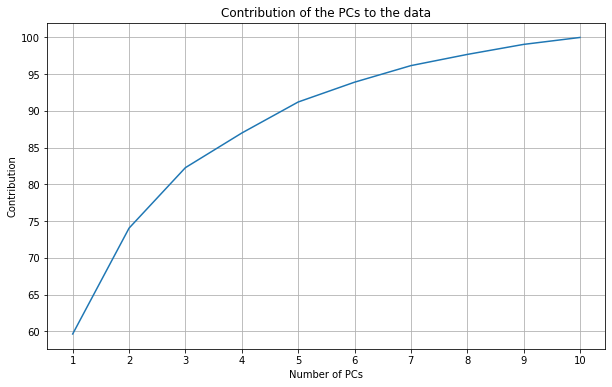

In [308]:
plt.figure(figsize=(10,6))
plt.plot(list(range(1, 11)), [i*100 for i in contributions])
plt.title("Contribution of the PCs to the data")
plt.xlabel("Number of PCs")
plt.ylabel("Contribution")
plt.grid()
plt.xticks(list(range(1,11)))
plt.show()

In [309]:
inputs= Z10[:, 0:9]

In [310]:
y_pca = LaEnc.fit_transform(y)

In [311]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, y_pca, test_size = 0.2, random_state = 3)

In [312]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [313]:
import tensorflow as tf

## Initializing the ANN

In [314]:
ANN_Model1 = tf.keras.models.Sequential()
ANN_Model2 = tf.keras.models.Sequential()
ANN_Model3 = tf.keras.models.Sequential()

## Adding the Input Layer

In [315]:
ANN_Model1.add(tf.keras.layers.Dense(units=10, activation='relu'))
ANN_Model2.add(tf.keras.layers.Dense(units=10, activation='relu'))
ANN_Model3.add(tf.keras.layers.Dense(units=10, activation='relu'))

We have created the first hidden layer by using the Dense class which is part of the layers module. This class accepts 2 inputs: units, which is the number of neurons that will be present in the respective layer and the activation which specifies which activation function to be used. We have decided to use the rectified linear unit, but there are other possibilities. 

## Adding the some Hidden Layers

For the first model let's try with a large hidden layer:

In [316]:
ANN_Model1.add(tf.keras.layers.Dense(units=64, activation='relu'))

One way to procede is to have the second hidden layer that is the double of the first one, so let's try it in the second model:

In [317]:
ANN_Model2.add(tf.keras.layers.Dense(units=22, activation='relu'))

While, for the third model, let's try to have more than just one hidden layer:

In [318]:
ANN_Model3.add(tf.keras.layers.Dense(units=6, activation='relu'))

## Adding the Output Layer

In this project, we have only two classes. So, in a binary classification problem (like this one), we will be allocating only one neuron (unit=1) to output this result. For the multiclass classification problem, we have to use more than one neuron in the output layer.

For the binary classification problems, the activation function that should be used is sigmoid, while for a multiclass classification problem, the activation function that should be used is softmax.

In [319]:
ANN_Model1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ANN_Model2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ANN_Model3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Compiling the ANN

Now I need to compile the ANN.

In [320]:
ANN_Model1.compile(optimizer='adam', loss='binary_crossentropy',  metrics = ['accuracy'])
ANN_Model2.compile(optimizer='adam', loss='binary_crossentropy',  metrics = ['accuracy'])
ANN_Model3.compile(optimizer='adam', loss='binary_crossentropy',  metrics = ['accuracy'])

## Training the ANN

In [324]:
h1 = ANN_Model1.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 200)
h2 = ANN_Model2.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 200)
h3 = ANN_Model3.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 200)

Epoch 1/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2315 - accuracy: 0.9142 - val_loss: 1.9452 - val_accuracy: 0.5254
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2309 - accuracy: 0.9142 - val_loss: 1.9374 - val_accuracy: 0.5424
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2308 - accuracy: 0.9227 - val_loss: 1.9319 - val_accuracy: 0.5424
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2294 - accuracy: 0.9227 - val_loss: 1.9414 - val_accuracy: 0.5424
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2293 - accuracy: 0.9227 - val_loss: 1.9515 - val_accuracy: 0.5424
Epoch 6/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2290 - accuracy: 0.9185 - val_loss: 1.9648 - val_accuracy: 0.5424
Epoch 7/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2286 - accuracy: 0.9185 - val_loss: 1.9587 - val_accuracy: 0.5424
Epoch 8/200
8/8 [========

8/8 [==============================] - 0s 8ms/step - loss: 0.2092 - accuracy: 0.9227 - val_loss: 2.1799 - val_accuracy: 0.5254
Epoch 60/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2087 - accuracy: 0.9270 - val_loss: 2.1798 - val_accuracy: 0.5254
Epoch 61/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2095 - accuracy: 0.9270 - val_loss: 2.1656 - val_accuracy: 0.5254
Epoch 62/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2086 - accuracy: 0.9227 - val_loss: 2.1812 - val_accuracy: 0.5254
Epoch 63/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2084 - accuracy: 0.9270 - val_loss: 2.1803 - val_accuracy: 0.5254
Epoch 64/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2081 - accuracy: 0.9270 - val_loss: 2.1822 - val_accuracy: 0.5254
Epoch 65/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2070 - accuracy: 0.9270 - val_loss: 2.2121 - val_accuracy: 0.5254
Epoch 66/200
8/8 [===============

8/8 [==============================] - 0s 5ms/step - loss: 0.1898 - accuracy: 0.9313 - val_loss: 2.4467 - val_accuracy: 0.5254
Epoch 118/200
8/8 [==============================] - 0s 4ms/step - loss: 0.1901 - accuracy: 0.9227 - val_loss: 2.4534 - val_accuracy: 0.5254
Epoch 119/200
8/8 [==============================] - 0s 5ms/step - loss: 0.1896 - accuracy: 0.9270 - val_loss: 2.4632 - val_accuracy: 0.5254
Epoch 120/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1890 - accuracy: 0.9227 - val_loss: 2.4636 - val_accuracy: 0.5254
Epoch 121/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1888 - accuracy: 0.9313 - val_loss: 2.4532 - val_accuracy: 0.5254
Epoch 122/200
8/8 [==============================] - 0s 5ms/step - loss: 0.1884 - accuracy: 0.9313 - val_loss: 2.4542 - val_accuracy: 0.5254
Epoch 123/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1878 - accuracy: 0.9313 - val_loss: 2.4466 - val_accuracy: 0.5254
Epoch 124/200
8/8 [========

8/8 [==============================] - 0s 10ms/step - loss: 0.1724 - accuracy: 0.9356 - val_loss: 2.6520 - val_accuracy: 0.5424
Epoch 176/200
8/8 [==============================] - 0s 4ms/step - loss: 0.1720 - accuracy: 0.9356 - val_loss: 2.6683 - val_accuracy: 0.5424
Epoch 177/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1716 - accuracy: 0.9356 - val_loss: 2.6697 - val_accuracy: 0.5424
Epoch 178/200
8/8 [==============================] - 0s 5ms/step - loss: 0.1712 - accuracy: 0.9356 - val_loss: 2.6807 - val_accuracy: 0.5424
Epoch 179/200
8/8 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.9356 - val_loss: 2.6739 - val_accuracy: 0.5424
Epoch 180/200
8/8 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.9399 - val_loss: 2.7015 - val_accuracy: 0.5424
Epoch 181/200
8/8 [==============================] - 0s 5ms/step - loss: 0.1715 - accuracy: 0.9356 - val_loss: 2.7009 - val_accuracy: 0.5424
Epoch 182/200
8/8 [=======

8/8 [==============================] - 0s 5ms/step - loss: 0.3119 - accuracy: 0.8584 - val_loss: 0.8425 - val_accuracy: 0.6102
Epoch 34/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3115 - accuracy: 0.8670 - val_loss: 0.8388 - val_accuracy: 0.6271
Epoch 35/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3109 - accuracy: 0.8627 - val_loss: 0.8483 - val_accuracy: 0.6102
Epoch 36/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3101 - accuracy: 0.8498 - val_loss: 0.8530 - val_accuracy: 0.6102
Epoch 37/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3096 - accuracy: 0.8541 - val_loss: 0.8501 - val_accuracy: 0.6102
Epoch 38/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3098 - accuracy: 0.8627 - val_loss: 0.8436 - val_accuracy: 0.6102
Epoch 39/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3089 - accuracy: 0.8627 - val_loss: 0.8439 - val_accuracy: 0.6102
Epoch 40/200
8/8 [===============

8/8 [==============================] - 0s 5ms/step - loss: 0.2870 - accuracy: 0.8627 - val_loss: 0.8753 - val_accuracy: 0.6271
Epoch 92/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2868 - accuracy: 0.8627 - val_loss: 0.8668 - val_accuracy: 0.6271
Epoch 93/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2866 - accuracy: 0.8670 - val_loss: 0.8665 - val_accuracy: 0.6271
Epoch 94/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2857 - accuracy: 0.8670 - val_loss: 0.8664 - val_accuracy: 0.6271
Epoch 95/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2856 - accuracy: 0.8670 - val_loss: 0.8660 - val_accuracy: 0.6271
Epoch 96/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2865 - accuracy: 0.8670 - val_loss: 0.8775 - val_accuracy: 0.6271
Epoch 97/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2845 - accuracy: 0.8712 - val_loss: 0.8791 - val_accuracy: 0.6271
Epoch 98/200
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.2599 - accuracy: 0.8884 - val_loss: 0.9901 - val_accuracy: 0.6102
Epoch 150/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2590 - accuracy: 0.8884 - val_loss: 0.9789 - val_accuracy: 0.6102
Epoch 151/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2585 - accuracy: 0.8884 - val_loss: 0.9816 - val_accuracy: 0.5932
Epoch 152/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2580 - accuracy: 0.8884 - val_loss: 0.9832 - val_accuracy: 0.5932
Epoch 153/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2575 - accuracy: 0.8884 - val_loss: 0.9780 - val_accuracy: 0.5932
Epoch 154/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2571 - accuracy: 0.8884 - val_loss: 0.9762 - val_accuracy: 0.5932
Epoch 155/200
8/8 [==============================] - 0s 5ms/step - loss: 0.2570 - accuracy: 0.8927 - val_loss: 0.9802 - val_accuracy: 0.5932
Epoch 156/200
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.3902 - accuracy: 0.8026 - val_loss: 0.9353 - val_accuracy: 0.5763
Epoch 8/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3898 - accuracy: 0.8026 - val_loss: 0.9358 - val_accuracy: 0.5763
Epoch 9/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3894 - accuracy: 0.8026 - val_loss: 0.9370 - val_accuracy: 0.5763
Epoch 10/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3894 - accuracy: 0.8026 - val_loss: 0.9403 - val_accuracy: 0.5763
Epoch 11/200
8/8 [==============================] - 0s 7ms/step - loss: 0.3902 - accuracy: 0.7983 - val_loss: 0.9440 - val_accuracy: 0.5763
Epoch 12/200
8/8 [==============================] - 0s 8ms/step - loss: 0.3889 - accuracy: 0.8026 - val_loss: 0.9398 - val_accuracy: 0.5763
Epoch 13/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3888 - accuracy: 0.8112 - val_loss: 0.9367 - val_accuracy: 0.5763
Epoch 14/200
8/8 [=================

8/8 [==============================] - 0s 8ms/step - loss: 0.3777 - accuracy: 0.8069 - val_loss: 0.9716 - val_accuracy: 0.5763
Epoch 66/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3775 - accuracy: 0.8112 - val_loss: 0.9709 - val_accuracy: 0.5763
Epoch 67/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3774 - accuracy: 0.8155 - val_loss: 0.9734 - val_accuracy: 0.5763
Epoch 68/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3776 - accuracy: 0.8026 - val_loss: 0.9774 - val_accuracy: 0.5763
Epoch 69/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3772 - accuracy: 0.8026 - val_loss: 0.9793 - val_accuracy: 0.5763
Epoch 70/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3774 - accuracy: 0.8026 - val_loss: 0.9801 - val_accuracy: 0.5763
Epoch 71/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3773 - accuracy: 0.8069 - val_loss: 0.9791 - val_accuracy: 0.5763
Epoch 72/200
8/8 [===============

8/8 [==============================] - 0s 10ms/step - loss: 0.3644 - accuracy: 0.8155 - val_loss: 1.0083 - val_accuracy: 0.5763
Epoch 124/200
8/8 [==============================] - 0s 4ms/step - loss: 0.3651 - accuracy: 0.8112 - val_loss: 1.0075 - val_accuracy: 0.5593
Epoch 125/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3640 - accuracy: 0.8155 - val_loss: 1.0120 - val_accuracy: 0.5763
Epoch 126/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3638 - accuracy: 0.8197 - val_loss: 1.0150 - val_accuracy: 0.5932
Epoch 127/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3642 - accuracy: 0.8112 - val_loss: 1.0187 - val_accuracy: 0.5763
Epoch 128/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3629 - accuracy: 0.8197 - val_loss: 1.0159 - val_accuracy: 0.5932
Epoch 129/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3638 - accuracy: 0.8197 - val_loss: 1.0144 - val_accuracy: 0.5763
Epoch 130/200
8/8 [=======

8/8 [==============================] - 0s 5ms/step - loss: 0.3530 - accuracy: 0.8197 - val_loss: 1.0717 - val_accuracy: 0.5085
Epoch 182/200
8/8 [==============================] - 0s 8ms/step - loss: 0.3538 - accuracy: 0.8197 - val_loss: 1.0736 - val_accuracy: 0.5254
Epoch 183/200
8/8 [==============================] - 0s 9ms/step - loss: 0.3529 - accuracy: 0.8197 - val_loss: 1.0756 - val_accuracy: 0.5085
Epoch 184/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3531 - accuracy: 0.8240 - val_loss: 1.0748 - val_accuracy: 0.5254
Epoch 185/200
8/8 [==============================] - 0s 6ms/step - loss: 0.3521 - accuracy: 0.8240 - val_loss: 1.0759 - val_accuracy: 0.5254
Epoch 186/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3521 - accuracy: 0.8240 - val_loss: 1.0772 - val_accuracy: 0.5254
Epoch 187/200
8/8 [==============================] - 0s 5ms/step - loss: 0.3526 - accuracy: 0.8240 - val_loss: 1.0803 - val_accuracy: 0.5254
Epoch 188/200
8/8 [========

### Plotting learning curves

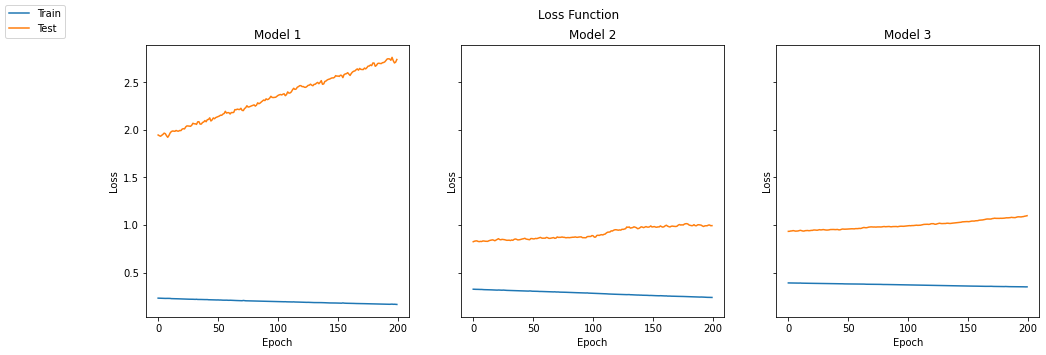

In [325]:
from matplotlib import legend
h = [h1, h2, h3]
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize = (16,5))
fig.suptitle('Loss Function')
for i in range(3):
  axs[i].plot(h[i].history['loss'])
  axs[i].plot(h[i].history['val_loss'])
  axs[i].set_title("Model {}".format(i + 1))

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

fig.legend(labels=['Train','Test'], loc="upper left")
plt.show()

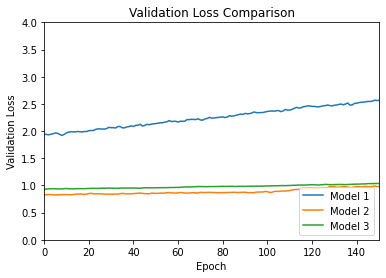

In [326]:
for i in range(3):
  plt.plot(h[i].history['val_loss'])

plt.title('Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.xlim(0, 150)
plt.ylim(0, 4)
plt.legend(['Model 1', 'Model 2', 'Model 3'], loc='lower right')
plt.show()

## Evaluating the Model

In [327]:
models = [ANN_Model1, ANN_Model2, ANN_Model3]

In [328]:
y_pred1 = ANN_Model1.predict(X_test)
y_pred2 = ANN_Model2.predict(X_test)
y_pred3 = ANN_Model3.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [329]:
accurancy = []
for model in models:
    accurancy.append(model.evaluate(X_test,y_test))
for i in range(len(accurancy)):
    print ("The accurancy of model", i + 1, "is", accurancy[i][1]*100, "%")

3/3 [==============================] - 0s 7ms/step - loss: 1.2573 - accuracy: 0.5616
The accurancy of model 1 is 52.054792642593384 %
The accurancy of model 2 is 52.054792642593384 %
The accurancy of model 3 is 56.16438388824463 %


## Cross Validation

In [330]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict 
predictions = []
keras_classifier = []
for model in models:
    keras_classifier.append(KerasClassifier(model = model, optimizer="adam", epochs=100, verbose=0))
for classifier in keras_classifier:
    predictions.append (cross_val_predict(classifier, X_train, y_train, cv=3))

INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmp1_kkgyo1/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpl8fspkcm/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpvix954k5/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpx0wn3rq_/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpho6u605q/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmp206ingtr/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpnj09hajo/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmp56oq_mpi/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpwv6yjmpl/assets


In [331]:
scores = []
cv_accurancy = []
for classifier in keras_classifier:
    scores.append(cross_val_score(classifier, X_train, y_train, scoring='accuracy', cv=5, verbose=0))

INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpxldbkrqp/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpyb6g4lzc/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpbjuirlip/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpz8pbubq7/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpdkytgix8/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpluba3bag/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpniy735z2/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmp3q7dnzt8/assets
INFO:tensorflow:Assets written to: ram:///var/folders/jq/_t3rmx8s6wx8dr3q_q8s3tyr0000gn/T/tmpf3rfihq4/assets
INFO:tensorflow:Ass

In [332]:
for i in range(len(scores)):
    cv_accurancy.append(np.average(scores[i])*100)
    print('The averaged prediction accuracy of model ', i+1, 'is equal to', round(cv_accurancy[i],4),"%") 

The averaged prediction accuracy of model  1 is equal to 69.1409 %
The averaged prediction accuracy of model  2 is equal to 71.1981 %
The averaged prediction accuracy of model  3 is equal to 66.1134 %
